# Frads walkthrough

In [ ]:
!git clone -b development https://github.com/shirubana/pyrad_workshop_24.git
cd pyrad_workshop_24
!pip install requirements.txt

In [1]:
import datetime
from pathlib import Path

import frads as fr
import numpy as np
import pyradiance as pr
import matplotlib.pyplot as plt
from pyenergyplus.dataset import ref_models

## Horizontal melanopic lux

### Make another scene

In [2]:
my_scene = pr.Scene(
    "my_scene", 
    surfaces=["Objects/floor.rad", "Objects/walls.rad", "Objects/ceiling.rad"], 
    materials=["Objects/materials.mat"], 
    sources=["Sources/gs_1221_1200.rad", "Sources/sky.rad"]
) 

### Generate grid from floor polygon

In [3]:
floor_primitives = fr.unpack_primitives("Objects/floor.rad")
floor_polygon = fr.parse_polygon(floor_primitives[0])  # taking the 1st primitive
grid = fr.gen_grid(floor_polygon, 1, 0.75)

### Trace

In [4]:
grid_rays = "\n".join(" ".join(map(str, row)) for row in grid)
nband = 20
params = pr.SamplingParameters(
    I=True,
    ab=3,
    ad=64,
    aa=0,
    lw=0.01,
    co=True,
    cs=nband,
)

result = pr.rtrace(grid_rays.encode(), my_scene.octree, params=params.args()+['-pM'], header=False, outform='f')

### Visualize

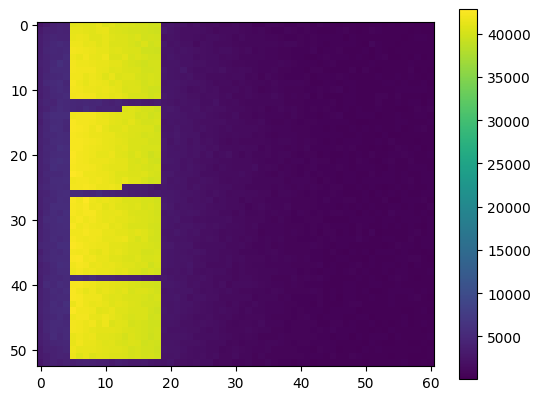

In [5]:
mlux = np.frombuffer(result, dtype=np.single).reshape(53, 61)   # grid dimensions
plt.imshow(mlux)
plt.colorbar()

In [6]:
settings = fr.Settings()
# Edit the number of parallel processes
settings.num_processors = 4

# Provide a wea file
settings.wea_file = "oak.wea"

## Phase simulation

### Setting up a workflow configuration from a dictionary
### see [here](https://lbnl-eta.github.io/frads/how-to/guide_rad2/) for setting up one item at a time.

In [7]:
workflow_config = {
    "settings": {
        "method": "3phase",
        "sky_basis": "r1",
        "epw_file": "",
        "wea_file": "Resources/slc.wea",
        "sensor_sky_matrix": ["-ab", "1"],
        "view_sky_matrix": ["-ab", "1"],
        "sensor_window_matrix": ["-ab", "1"],
        "view_window_matrix": ["-ab", "1"],
        "daylight_matrix": ["-ab", "1"],
        "num_processors": 32,
        "save_matrices": True,
    },
    "model": {
        "scene": {
            "files": ["Objects/walls.rad", "Objects/ceiling.rad", "Objects/floor.rad","Objects/ground.rad"]
        },
        "windows": {
            "window1": {
                "file": "Objects/upper_glass.rad",
                "matrix_name": "window1_matrix",
            },
                        "window2": {
                "file": "Objects/lower_glass.rad",
                "matrix_name": "window1_matrix",
            }
        },
        "materials": {
            "files": ["Objects/materials.mat"],
            "matrices": {"window1_matrix": {"matrix_file": "Resources/ms6858_kf.xml"}},
        },
        "sensors": {
            "view1": {"data": [[5, 5, 4, 0, 0, 1]]},
        },
    },
}
cfg = fr.WorkflowConfig.from_dict(workflow_config)

In [8]:
workflow = fr.ThreePhaseMethod(cfg)

In [ ]:
workflow.generate_matrices()

In [ ]:
workflow.calculate_sensor(
    sensor="view1",
    bsdf={"window1": "window1_matrix","window2": "window1_matrix"},
    time=datetime.datetime(2023, 1, 1, 12),
    dni=800,
    dhi=100,
)

In [ ]:
workflow2 = fr.TwoPhaseMethod(cfg)

In [ ]:
workflow2.generate_matrices()

In [ ]:
workflow2.calculate_sensor(
    sensor="view1",
    time=datetime.datetime(2023, 1, 1, 12),
    dni=800,
    dhi=100,
)

## EnergyPlus and Radiance

### Load an EnergyPlus model
The model can be an .idf file or .epJSON file.
Here we are loading a small office prototypical building model that comes with pyenergyplus

In [2]:
epmodel = fr.load_energyplus_model(ref_models['small_office'])

### Load an EnergyPlus model
The model can be an .idf file or .epJSON file.
Here we are loading the small office prototype building comes with pyenergyplus

### Create Glazing Systems (BSDF)
#### See [here](https://lbnl-eta.github.io/frads/how-to/guide_ep2/) for more options

In [3]:
ec60 = fr.create_glazing_system(
    name="ec_60",
    layers=[
        Path("Resources/igsdb_product_7406.json"), # electrochromic 60%
        Path("Resources/igsdb_product_14028.json"), # clear glass
    ],
)
ec18 = fr.create_glazing_system(
    name="ec_60",
    layers=[
        Path("Resources/igsdb_product_7404.json"), # electrochromic 18%
        Path("Resources/igsdb_product_14028.json"), # clear glass
    ],
)
epmodel.add_glazing_system(ec60)
epmodel.add_glazing_system(ec18)

In [4]:
epsetup = fr.EnergyPlusSetup(epmodel, enable_radiance=True)

/home/taoningw/Projects/pyrad_workshop_24/.venv/lib/python3.12/site-packages/pydantic/main.py:415: UserWarning: Pydantic serializer warnings:
  Expected `Union[EvaporativeCondenserPumpRatedPowerConsumption, literal['Autosize']]` but got `float` - serialized value may not be as expected
  Expected `Union[EvaporativeCondenserPumpRatedPowerConsumption, literal['Autosize']]` but got `float` - serialized value may not be as expected
  Expected `Union[EvaporativeCondenserPumpRatedPowerConsumption, literal['Autosize']]` but got `float` - serialized value may not be as expected
  Expected `Union[EvaporativeCondenserPumpRatedPowerConsumption, literal['Autosize']]` but got `float` - serialized value may not be as expected
  Expected `Union[EvaporativeCondenserPumpRatedPowerConsumption, literal['Autosize']]` but got `float` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_json(


In [5]:
# epsetup.run(design_day=True)

### Runtime call back

In [6]:
def controller(state):
    # check if the api is fully ready
    if not epsetup.api.exchange.api_data_fully_ready(state):
        return

    # control facade shading state based on exterior solar irradiance
    # get exterior solar irradiance
    ext_irradiance = epsetup.get_variable_value(
        name="Surface Outside Face Incident Solar Radiation Rate per Area",
        key="Perimeter_ZN_1_wall_south_Window_1",
    )
    # facade shading state control algorithm
    if ext_irradiance <= 300:
        ec = "60"
    else:
        ec = "18"
    cfs_state = f"ec_{ec}"
    # actuate facade shading state
    epsetup.actuate_cfs_state(
        window="Perimeter_ZN_1_wall_south_Window_1",
        cfs_state=cfs_state,
    )
    # calculate average workplane illuminance using Radiance
    avg_wpi = epsetup.calculate_wpi(
        zone="Perimeter_ZN_1",
        cfs_name={
            "Perimeter_ZN_1_wall_south_Window_1": cfs_state,
            "Perimeter_ZN_1_wall_south_Window_2": cfs_state,
            "Perimeter_ZN_1_wall_south_Window_3": cfs_state,
            "Perimeter_ZN_1_wall_south_Window_4": cfs_state,
            "Perimeter_ZN_1_wall_south_Window_5": cfs_state,
            "Perimeter_ZN_1_wall_south_Window_6": cfs_state,
            "Perimeter_ZN_1_wall_south_door": cfs_state,
        },
    ).mean()
    # electric lighting power control algorithm
    # if occupant_count > 0:
    #     lighting_power = (
    #         1 - min(avg_wpi / 500, 1)
    #     ) * 1200  # 1200W is the nominal lighting power density
    # else:
    #     lighting_power = 0
    # actuate electric lighting power
    # epsetup.actuate_lighting_power(
    #     light="Perimeter_ZN_1",
    #     value=lighting_power,
    # )

In [7]:
epsetup.set_callback(
    "callback_begin_system_timestep_before_predictor",
    controller
)

In [ ]:
epsetup.run(design_day=True)